# T2* map calculation tutorial

Start by importing the required libraries and defining some settings:

In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from ukat.data import fetch
from ukat.mapping.t2star import T2Star

# Ensure figures are rendered in the notebook
%matplotlib inline


Tell python where to store the T2* maps NIfTI files we will generate. We will store it in a directory called `t2star_calculation_output` in the `tutorials` directory.

In [2]:
# Initialise output path for T2star map
OUTPUT_DIR = os.path.join(os.getcwd(), "t2star_calculation_output")
OUTPUT_PATH_LOGLIN = os.path.join(OUTPUT_DIR, 'T2StarMapLoglin.nii.gz')
OUTPUT_PATH_2P_EXP = os.path.join(OUTPUT_DIR, 'T2StarMap2pexp.nii.gz')

Retrieve T2* test data using our data fetcher.
This will return 3 variables:
* `image`: a 4D array with the magnitude data at all echo times.
* `affine`: the affine matrix for the data (needed to later write a new NIfTI file).
* `te`: an array containing the echo times, in seconds.

In [3]:
# Fetch test data
image, affine, te = fetch.r2star_philips()
te = te * 1000  # convert TE to ms

Compute the T2* maps using the `T2Star` class implemented in `mapping`. We'll start with the logarithmic linear fitting
method (`loglin`).

In [8]:
# Initialise the loglin mapping object
mapper_loglin = T2Star(image, te, method='loglin')

# Extract the T2* map from the object
t2star_loglin = mapper_loglin.t2star_map

100%|██████████| 81920/81920 [00:06<00:00, 11736.47it/s]


Now we're going to calculate the T2* map using the two parameter exponential curve fitting method (`2p_exp`). This method
takes quite a lot longer but is more accurate for T2* less than 20 ms such as in the liver.

In [13]:
# Initialise the loglin mapping object
mapper_2p_exp = T2Star(image, te, method='2p_exp')

# Extract the T2* map from the object
t2star_2p_exp = mapper_2p_exp.t2star_map

100%|██████████| 81920/81920 [02:18<00:00, 590.43it/s] 


Display a central slice of the T2* maps and the difference between them. Note the units are _ms_.

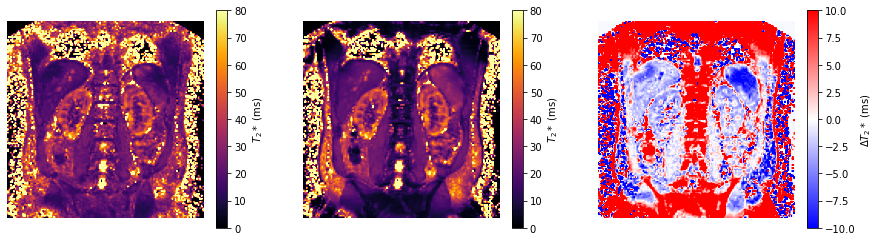

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Display a central slice of the log linear T2* map
im = ax1.imshow(np.rot90(t2star_loglin[:, :, 2]), cmap='inferno', clim=(0, 80))
cb = fig.colorbar(im, ax=ax1)
cb.set_label('$T_2*$ (ms)')
ax1.axis('off')

# Display a central slice of the exponential curve fit T2* map
im = ax2.imshow(np.rot90(t2star_2p_exp[:, :, 2]), cmap='inferno', clim=(0, 80))
cb = fig.colorbar(im, ax=ax2)
cb.set_label('$T_2*$ (ms)')
ax2.axis('off')

# Display the difference between the two mapping methods
im = ax3.imshow(np.rot90(t2star_loglin[:, :, 2] - t2star_2p_exp[:, :, 2]), cmap='bwr', clim=(-10, 10))
cb = fig.colorbar(im, ax=ax3)
cb.set_label('$\Delta T_2*$ (ms)')
ax3.axis('off')

plt.show()

We can also view the corresponding R2* map.

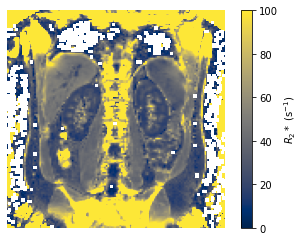

In [31]:
r2star_2p_exp = mapper_2p_exp.r2star_map()

fig, ax = plt.subplots()
im = ax.imshow(np.rot90(r2star_2p_exp[:, :, 2] * 1000), cmap='cividis', clim=(0, 100))
cb = fig.colorbar(im)
cb.set_label('$R_2*$ (s$^{-1})$')
ax.axis('off')
plt.show()

Now we'll save the resulting T2* maps as a NIfTI files:

In [26]:
t2star_nifti_object_loglin = nib.Nifti1Image(t2star_loglin, affine=affine)
nib.save(t2star_nifti_object_loglin, OUTPUT_PATH_LOGLIN)

t2star_nifti_object_2p_exp = nib.Nifti1Image(t2star_2p_exp, affine=affine)
nib.save(t2star_nifti_object_2p_exp, OUTPUT_PATH_2P_EXP)